# Sheridan Kamal

## DATA 71200 - Project 2 (Due 4/29/2020, 11:59p)

### Project
For my project, I will be using time series data and machine learning methods to predict recessions. In this portion of the project, I will be using the training and testing sets created in the previous project to create two supervised machine learning models. I will be creating Logistic Regression models with scaled and unscaled data and Decision Tree Classifier models with scaled and unscaled data. The best Logistic Regression model is the model with the scaled data and the best Decision Tree Classifier model is the model with the scaled data.

### Data
I will be using the CSV file named 'Project Dataset.csv' that I generated in the previous project. Since this file has all of the features I wish to use for my model and the prediction labels are already encoded there are no data issues to deal with. For the models that require scaling of the data, I will be using pipelines to scale the data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data = pd.read_csv('Project Dataset.csv', sep = ',', parse_dates = ['Date'], index_col = 'Date')
data.head()

,10yr Tbond,2yr Spread,Fedrate,% Change Payrolls,CPI,% Change 12M,Recession
Date,,,,,,,
1976-06-01,7.86,0.80,5.48,0.000807,56.7,0.091205,0.0
1976-07-01,7.83,0.98,5.31,0.002154,57.0,0.153168,0.0
1976-08-01,7.77,1.14,5.29,0.001974,57.3,0.169327,0.0
1976-09-01,7.59,1.17,5.25,0.002359,57.6,0.226975,0.0
1976-10-01,7.41,1.43,5.02,0.000238,57.9,0.144672,0.0


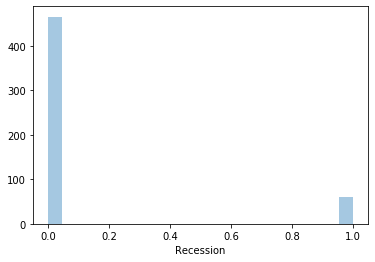

In [2]:
sns.distplot(data.loc[:, 'Recession'], kde=False) #0 = No Recession, 1 = Recession

In [3]:
#70/30 sequential train-test split
from sklearn.model_selection import train_test_split

X = data.iloc[:, 0:-1]
y = data.loc[:, 'Recession']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, shuffle=False, random_state=1)

In [4]:
#For cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

index = 1
for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    print('Split %d.' % index, 'Training set observations: %d,' % len(train_index), 'Testing set observations: %d' % len(test_index))
    index += 1

Split 1. Training set observations: 91, Testing set observations: 87
Split 2. Training set observations: 178, Testing set observations: 87
Split 3. Training set observations: 265, Testing set observations: 87
Split 4. Training set observations: 352, Testing set observations: 87
Split 5. Training set observations: 439, Testing set observations: 87


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression()

c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

logreg_cv = GridSearchCV(logreg, param_grid, cv=tscv)

logreg_cv.fit(X_train, y_train)

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))
print(classification_report(y_test, logreg_cv.predict(X_test)))

Tuned Logistic Regression Parameters: {'C': 1e-05, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.8918032786885245
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       139
         1.0       0.00      0.00      0.00        19

    accuracy                           0.88       158
   macro avg       0.44      0.50      0.47       158
weighted avg       0.77      0.88      0.82       158



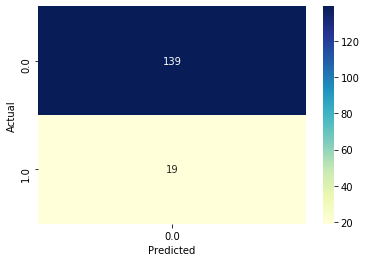

In [6]:
confusion_matrix = pd.crosstab(y_test, logreg_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")

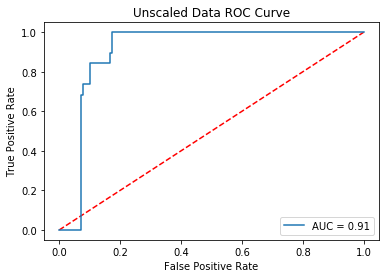

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]

logreg_roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % logreg_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unscaled Data ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()),
        ('LogReg', LogisticRegression())]

parameters = {'LogReg__C': c_space, 'LogReg__penalty': ['l1', 'l2']}

pipeline = Pipeline(steps)

logreg_scaled = GridSearchCV(pipeline, parameters, cv=tscv)

logreg_scaled.fit(X_train, y_train)

print("Tuned Logistic Regression with Scaling Parameters: {}".format(logreg_scaled.best_params_)) 
print('Tuned Logistic Regression with Scaling Accuracy: {}'.format(logreg_scaled.score(X_test, y_test)))
print(classification_report(y_test, logreg_scaled.predict(X_test)))

Tuned Logistic Regression with Scaling Parameters: {'LogReg__C': 3.727593720314938, 'LogReg__penalty': 'l2'}
Tuned Logistic Regression with Scaling Accuracy: 0.9367088607594937
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       139
         1.0       0.85      0.58      0.69        19

    accuracy                           0.94       158
   macro avg       0.90      0.78      0.83       158
weighted avg       0.93      0.94      0.93       158



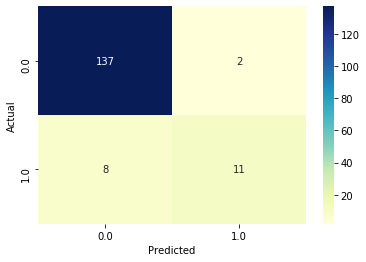

In [9]:
confusion_matrix_2 = pd.crosstab(y_test, logreg_scaled.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_2, annot=True, fmt='d', cmap="YlGnBu")

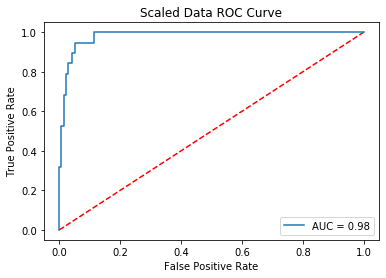

In [10]:
y_pred_prob_scaled = logreg_scaled.predict_proba(X_test)[:,1]

logreg_scaled_roc_auc = roc_auc_score(y_test, y_pred_prob_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_scaled)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % logreg_scaled_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Scaled Data ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"max_depth": [1],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()

tree_cv = RandomizedSearchCV(tree, param_dist, cv=tscv)

tree_cv.fit(X_train, y_train)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Tuned Decision Tree Accuracy: {}".format(tree_cv.best_score_))
print(classification_report(y_test, tree_cv.predict(X_test)))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 6}
Tuned Decision Tree Accuracy: 0.9147540983606557
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       139
         1.0       0.00      0.00      0.00        19

    accuracy                           0.88       158
   macro avg       0.44      0.50      0.47       158
weighted avg       0.77      0.88      0.82       158



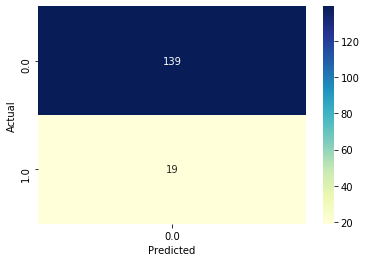

In [12]:
confusion_matrix_3 = pd.crosstab(y_test, tree_cv.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_3, annot=True, fmt='d', cmap="YlGnBu")

In [13]:
steps2 = [('scaler', StandardScaler()),
        ('TreeClass', DecisionTreeClassifier())]

parameter = {"TreeClass__max_depth": [1],
              "TreeClass__max_features": randint(1, 9),
              "TreeClass__min_samples_leaf": randint(1, 9),
              "TreeClass__criterion": ["gini", "entropy"]}

pipeline2 = Pipeline(steps2)

tree_scaled = RandomizedSearchCV(pipeline2, parameter, cv=tscv)

tree_scaled.fit(X_train, y_train)

print("Tuned Decision Tree with Scaling Parameters: {}".format(tree_scaled.best_params_)) 
print('Tuned Decision Tree with Scaling Accuracy: {}'.format(tree_scaled.score(X_test, y_test)))
print(classification_report(y_test, tree_scaled.predict(X_test)))

Tuned Decision Tree with Scaling Parameters: {'TreeClass__criterion': 'gini', 'TreeClass__max_depth': 1, 'TreeClass__max_features': 5, 'TreeClass__min_samples_leaf': 4}
Tuned Decision Tree with Scaling Accuracy: 0.930379746835443
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       139
         1.0       0.68      0.79      0.73        19

    accuracy                           0.93       158
   macro avg       0.83      0.87      0.85       158
weighted avg       0.94      0.93      0.93       158



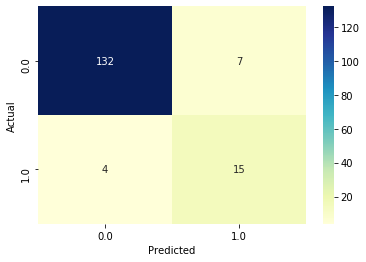

In [14]:
confusion_matrix_4 = pd.crosstab(y_test, tree_scaled.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_4, annot=True, fmt='d', cmap="YlGnBu")